# helper functionalities

In [2]:
import neptune as neptune
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def get_neptune_table(tags, negative_tags=None):
    project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDY0ZDI5Ni05YWU3LTQyNGYtYmY4My1hZTFkY2EzYmUwMjgifQ=="
    )
    runs_table = project.fetch_runs_table(tag=tags).to_pandas()

    # If negative tags are provided, filter them out
    if negative_tags is not None:
        for neg_tag in negative_tags:
            runs_table = runs_table[~runs_table['sys/tags'].apply(lambda x: neg_tag in x)]

    print(f'table downloaded\nshape: {runs_table.shape}')
    return runs_table


In [15]:
def get_neptune_table_by_ids(run_ids):
    project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDY0ZDI5Ni05YWU3LTQyNGYtYmY4My1hZTFkY2EzYmUwMjgifQ=="
    )
    
    runs_table = project.fetch_runs_table(id=run_ids).to_pandas()
    
    print(f'table downloaded by IDs\nshape: {runs_table.shape}')
    return runs_table


# STD sota

In [16]:
def get_loss_per_step(runs_table, loss_per=100):
    loss_dict = {}
    for _, run_row in runs_table.iterrows():
        run_id = run_row['sys/id']  # Assuming 'sys/id' is the run identifier
        print(f'run ID: {run_id}')
        project_name = "pmtest/llm-random"
        # run_id = "LLMRANDOM-2078"
        run = neptune.init_run(project=project_name, with_id=run_id, mode="read-only")
        loss_dict[run_id] = run[f"loss_interval/{loss_per}"].fetch_values()
    return loss_dict

In [17]:
def plot_std(runs_spec_type, runs_1, runs_2, title, name_1, name_2, show_plot=False, save_to=None, figsize=(10, 10), ylim=None, x_start=None, loss_per=100):
    b_v_r_negative_tags = ['remove']
    if runs_spec_type == 'tags':
        table_1 = get_neptune_table(runs_1, b_v_r_negative_tags)
        table_2 = get_neptune_table(runs_2, b_v_r_negative_tags)
    elif runs_spec_type == 'ids':
        table_1 = get_neptune_table_by_ids(runs_1)
        table_2 = get_neptune_table_by_ids(runs_2)
    loss_dict_1 = get_loss_per_step(table_1, loss_per=loss_per)
    loss_dict_2 = get_loss_per_step(table_2, loss_per=loss_per)
    
    # Concatenate the dataframes into one
    df_1 = pd.concat([df.set_index('step')['value'] for df in loss_dict_1.values()], axis=1)
    df_2 = pd.concat([df.set_index('step')['value'] for df in loss_dict_2.values()], axis=1)

    # Calculate mean and standard deviation
    df_1['mean'] = df_1.mean(axis=1)
    df_1['std'] = df_1.std(axis=1)

    # Calculate mean and standard deviation
    df_2['mean'] = df_2.mean(axis=1)
    df_2['std'] = df_2.std(axis=1)

    # Reset the index to have 'step' as a column again
    df_1 = df_1[['mean', 'std']].reset_index()
    df_2 = df_2[['mean', 'std']].reset_index()

    # Create the plot
    plt.figure(figsize=figsize)

    # baseline
    steps = df_1['step'].values
    mean_values = df_1['mean'].values
    std_values = df_1['std'].values

    if x_start is not None:
        first_index = np.argmax(steps > x_start)
        steps = steps[first_index:]
        mean_values = mean_values[first_index:]
        std_values = std_values[first_index:]

    plt.plot(steps, mean_values, label=f'{name_1} - mean', color='blue')
    plt.fill_between(steps, mean_values - std_values, mean_values + std_values, 
                    color='blue', alpha=0.2, label=f'{name_1} - standard deviation')

    #relative
    steps = df_2['step'].values
    mean_values = df_2['mean'].values
    std_values = df_2['std'].values

    if x_start is not None:
        steps = steps[first_index:]
        mean_values = mean_values[first_index:]
        std_values = std_values[first_index:]

    plt.plot(steps, mean_values, label=f'{name_2} - mean', color='red')
    plt.fill_between(steps, mean_values - std_values, mean_values + std_values, 
                    color='red', alpha=0.2, label=f'{name_2} - standard deviation')

    # # Plot individual dataframes from the dictionary
    # for run_id, df in relative_loss_dict.items():
    #     plt.plot(df['step'].values, df['value'].values, label=f'Run {run_id}')

    # Add labels and title
    plt.xlabel('Step')
    plt.ylabel('Loss')
    if ylim is not None:
        plt.ylim(ylim)
    plt.title(title)

    # Show legend
    plt.legend()
    if save_to is not None:
        plt.savefig(save_to)
    # Show the plot
    if show_plot:
        plt.show()

    # For baseline_df: Find the last step and the loss at that step
    last_step_baseline = df_1['step'].values[-1]
    loss_baseline = df_1['mean'].values[-1]
    std_baseline = df_1['std'].values[-1]

    # For relative_df: Find the first step where the mean loss is smaller than baseline's last mean loss
    smaller_loss_condition = df_2['mean'] < loss_baseline
    first_smaller_step_relative = df_2[smaller_loss_condition]['step'].values[0]
    loss_relative = df_2['mean'].values[-1]
    std_relative = df_2['std'].values[-1]

    gain = round(100 * first_smaller_step_relative / last_step_baseline, 2)

    return (last_step_baseline, loss_baseline, std_baseline), (first_smaller_step_relative, loss_relative, std_relative), gain

## MoE

Example

https://app.neptune.ai/pmtest/llm-random/
table downloaded by IDs
shape: (1, 313)
https://app.neptune.ai/pmtest/llm-random/
table downloaded by IDs
shape: (1, 323)
run ID: LLMRANDOM-14967
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14967
run ID: LLMRANDOM-14968
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14968


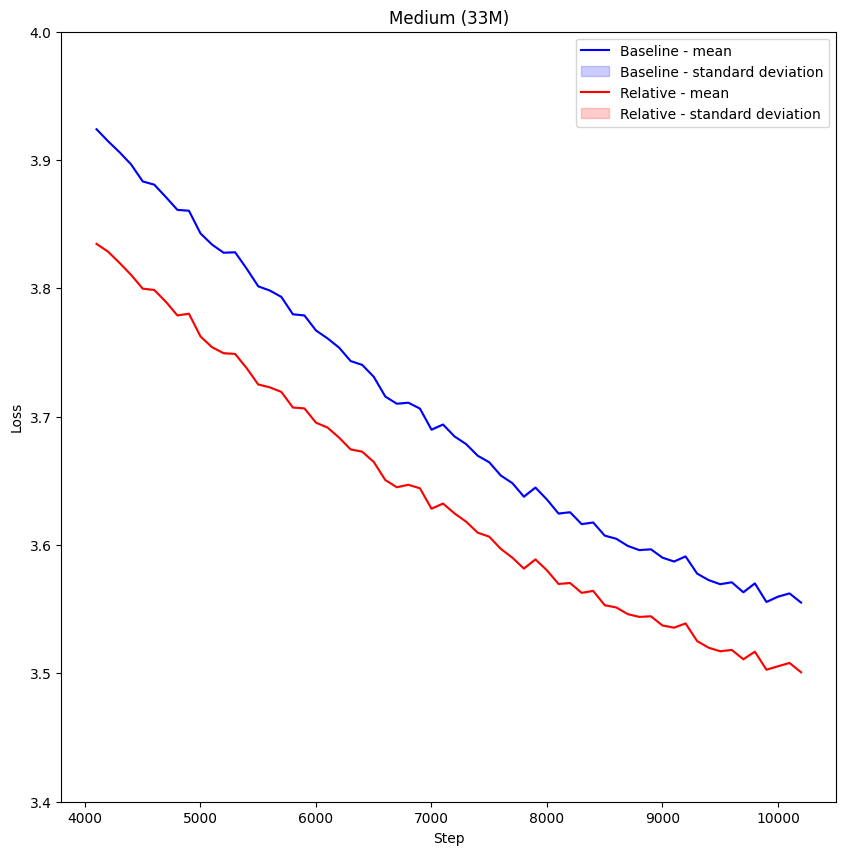

In [20]:
baseline_ids = ['LLMRANDOM-14967']
relative_ids = ['LLMRANDOM-14968']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    runs_spec_type='ids',
    runs_1=baseline_ids,
    runs_2=relative_ids,
    title='Medium (33M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='medium_relative_vs_baseline.png',
    ylim=(3.4, 4),
    x_start=4000,
)

In [21]:
print(f'gain: {100 - gain}')
tokens_per_step = 128 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000, 0)}M, relative tokens: {round(relative_steps * tokens_per_step / 1000000, 0)}M')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 16.67
total tokens: 668.0M, relative tokens: 557.0M
std baseline: 0.0, std relative: 0.0


### Medium

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 368)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 368)
run ID: LLMRANDOM-13676
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13676
run ID: LLMRANDOM-13675
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13675
run ID: LLMRANDOM-13544
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13544
run ID: LLMRANDOM-13677
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13677
run ID: LLMRANDOM-13674
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13674
run ID: LLMRANDOM-13563
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13563


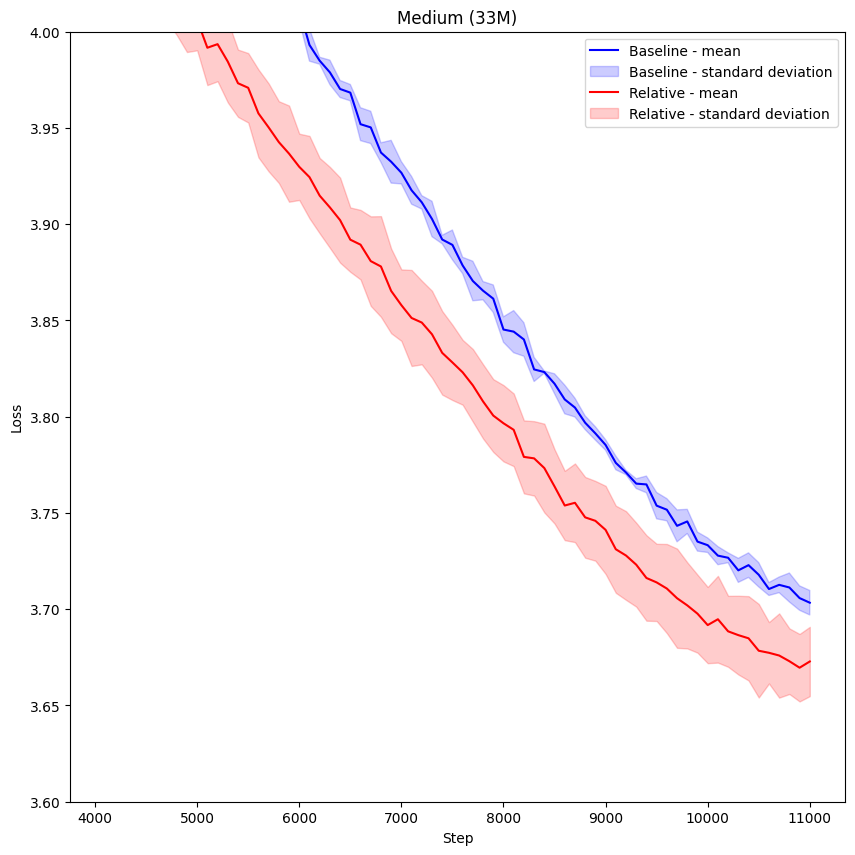

In [7]:
b_v_r_tags_baseline = ['relative_lr', 'relative_vs_baseline', 'medium', 'baseline']
b_v_r_tags_relative = ['relative_lr', 'relative_vs_baseline', 'medium', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Medium (33M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='medium_relative_vs_baseline.png',
    ylim=(3.6, 4),
    x_start=4000,
)

In [8]:
print(f'gain: {100 - gain}')
tokens_per_step = 128 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000, 0)}M, relative tokens: {round(relative_steps * tokens_per_step / 1000000, 0)}M')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 10.909999999999997
total tokens: 721.0M, relative tokens: 642.0M
std baseline: 0.0063629323396516895, std relative: 0.018001053673316125


### Base

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 537)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 537)
run ID: LLMRANDOM-13685
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13685
run ID: LLMRANDOM-13684
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13684
run ID: LLMRANDOM-13683
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13683
run ID: LLMRANDOM-13682
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13682
run ID: LLMRANDOM-13681
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13681
run ID: LLMRANDOM-13680
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13680


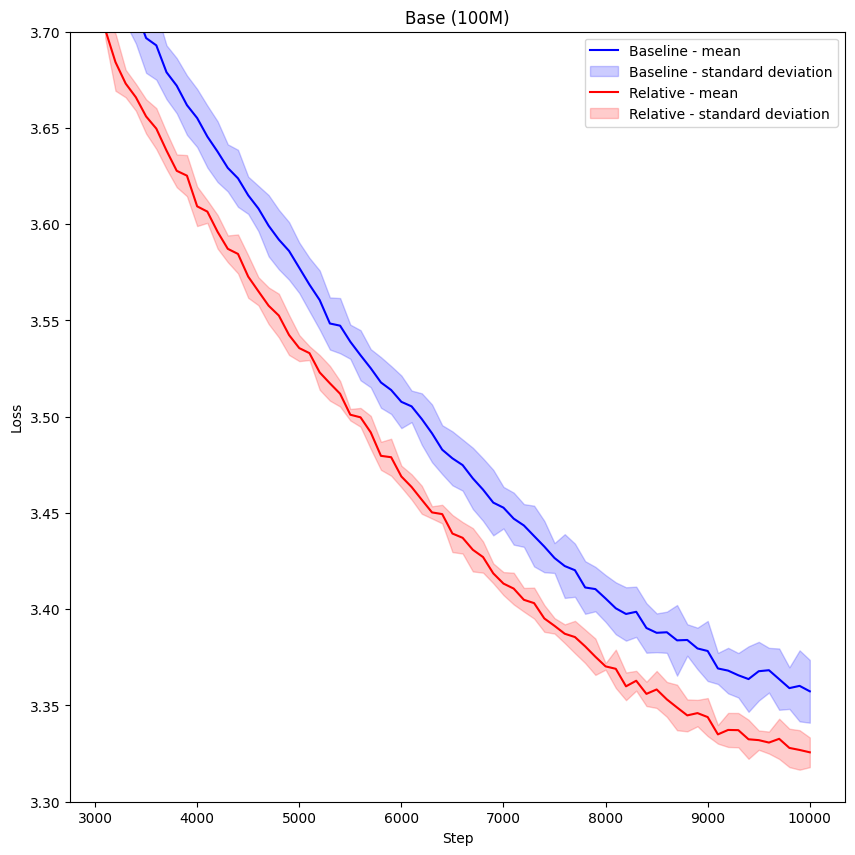

In [10]:
b_v_r_tags_baseline = ['relative_lr', 'relative_vs_baseline', 'base', 'baseline']
b_v_r_tags_relative = ['relative_lr', 'relative_vs_baseline', 'base', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Base (100M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='base_relative_vs_baseline.png',
    ylim=(3.3, 3.7),
    x_start=3000,
)

In [11]:
print(f'gain: {100 - gain}')
tokens_per_step = 256 * 1024
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000000, 2)}B, relative tokens: {round(relative_steps * tokens_per_step / 1000000000, 2)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 16.0
total tokens: 2.62B, relative tokens: 2.2B
std baseline: 0.016305231637389134, std relative: 0.007711703276944668


## Dense

### Medium

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 301)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 301)
run ID: LLMRANDOM-14025
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14025
run ID: LLMRANDOM-14024
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14024
run ID: LLMRANDOM-14023
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14023
run ID: LLMRANDOM-14022
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14022
run ID: LLMRANDOM-14021
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14021
run ID: LLMRANDOM-14020
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14020


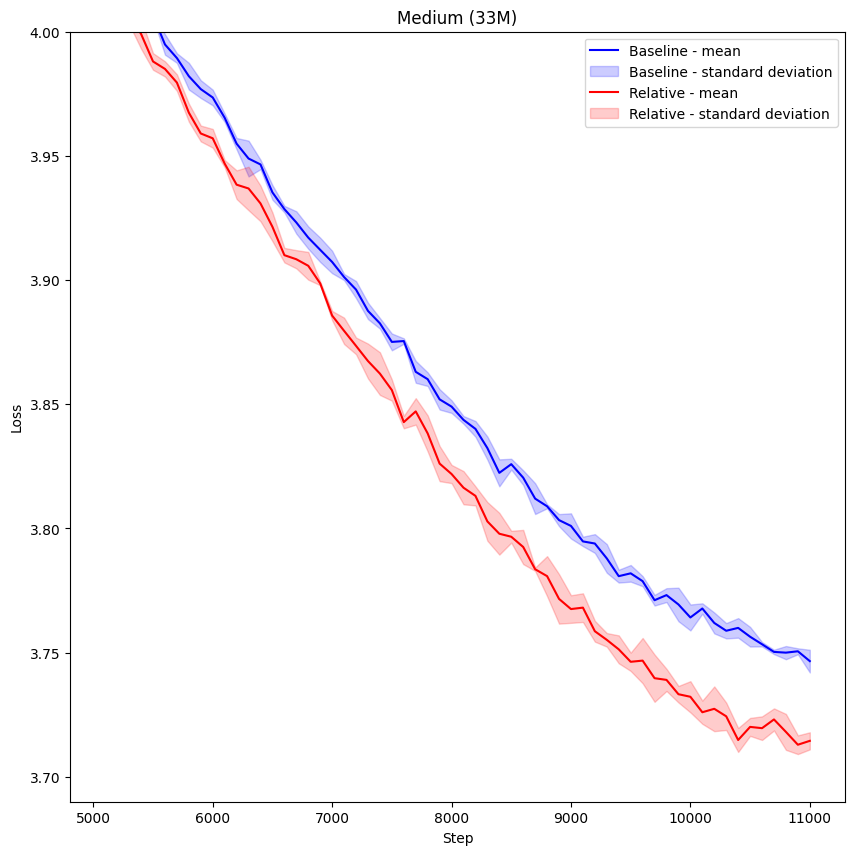

In [12]:
b_v_r_tags_baseline = ['dense', 'std', 'medium', 'baseline']
b_v_r_tags_relative = ['dense', 'std', 'medium', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Medium (33M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='medium_dense_relative_vs_baseline.png',
    ylim=(3.69, 4),
    x_start=5000,
)

In [13]:
print(f'gain: {100 - gain}')
tokens_per_step = 128 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000, 0)}M, relative tokens: {round(relative_steps * tokens_per_step / 1000000, 0)}M')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 13.64
total tokens: 721.0M, relative tokens: 623.0M
std baseline: 0.004564642509101271, std relative: 0.0034458252248241463


### Base

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 352)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 352)
run ID: LLMRANDOM-14045
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14045
run ID: LLMRANDOM-14044
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14044
run ID: LLMRANDOM-14043
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14043
run ID: LLMRANDOM-14040
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14040
run ID: LLMRANDOM-14039
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14039
run ID: LLMRANDOM-14038
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14038


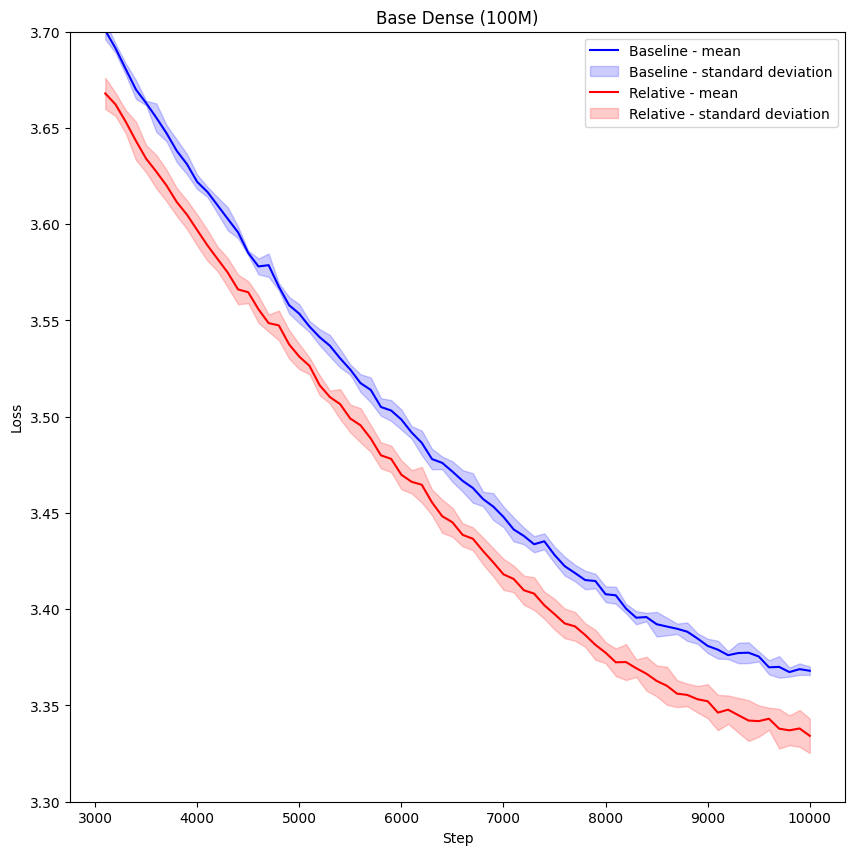

In [14]:
b_v_r_tags_baseline = ['dense', 'std', 'base', 'baseline']
b_v_r_tags_relative = ['dense', 'std', 'base', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Base Dense (100M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='base_dense_relative_vs_baseline.png',
    ylim=(3.3, 3.7),
    x_start=3000,
)

In [15]:
print(f'gain: {100 - gain}')
tokens_per_step = 256 * 1024
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000000, 2)}B, relative tokens: {round(relative_steps * tokens_per_step / 1000000000, 2)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 16.0
total tokens: 2.62B, relative tokens: 2.2B
std baseline: 0.002189126999109278, std relative: 0.008938206974454375


# U-plot std medium

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

def plot_std_component(table, component_name, start_end, ax=None):
    print(f'component_name: {component_name}, start_end: {start_end}')
    # Define the relevant column for grouping and analysis
    se_convert = {
        'start': 'relative_lr',
        'end': 'relative_scheduler_fraction'
    }
    dict_name = se_convert[start_end]
    args_column = f'args/{dict_name}/{component_name}'
    
    # Filter the table based on the presence of both component_name and start_end in the tags
    filtered_table = table[table['sys/tags'].apply(lambda tags: component_name in tags and start_end in tags)]

    # add optimal table
    optimal_table = table[table['sys/tags'].apply(lambda tags: 'baseline' in tags)]

    # Select the relevant columns
    columns = ['loss', args_column]
    # if component_name == "embedding_layer" and start_end == "start":
    #     print(f'shape: {filtered_table.shape}')
    #     print(f'optimal table:\n{filtered_table[columns].sort_values(args_column)}')
    filtered_table = filtered_table[columns]

    x_1_table = filtered_table[filtered_table[args_column] == 1]
    filtered_table = filtered_table[filtered_table[args_column] != 1]

    # Group the data by the `args_column` and calculate mean, min, and max of the `loss` column
    grouped_data = filtered_table.groupby(args_column)['loss'].agg(['mean', 'min', 'max']).reset_index()
    x_1_data = x_1_table.groupby(args_column)['loss'].agg(['mean', 'min', 'max']).reset_index()
    optimal_grouped = optimal_table.groupby(args_column)['loss'].agg(['mean', 'min', 'max']).reset_index()

    # Create a new axis if one is not provided
    if ax is None:
        fig, ax = plt.subplots()

    # Convert x_values to a NumPy array for errorbar plot
    x_values = np.round(grouped_data[args_column].values, 2)
    x_1_values = np.round(x_1_data[args_column].values, 2)
    x_optimal = np.round(optimal_grouped[args_column].values, 2)

    # Calculate yerr as the difference between the mean and min/max
    yerr = np.vstack([grouped_data['mean'] - grouped_data['min'], grouped_data['max'] - grouped_data['mean']])
    x_1_yerr = np.vstack([x_1_data['mean'] - x_1_data['min'], x_1_data['max'] - x_1_data['mean']])
    optimal_yerr = np.vstack([optimal_grouped['mean'] - optimal_grouped['min'], optimal_grouped['max'] - optimal_grouped['mean']])

    # Plot using errorbar
    ax.errorbar(x=x_values, y=grouped_data['mean'], yerr=yerr, fmt='o', color='blue', label='Other relative', capsize=5)
    ax.errorbar(x=x_1_values, y=x_1_data['mean'], yerr=x_1_yerr, fmt='o', color='red', label='Baseline (no relative)', capsize=5)
    ax.errorbar(x=x_optimal, y=optimal_grouped['mean'], yerr=optimal_yerr, fmt='o', color='green', label='Optimal relative', capsize=5)

    # Set the x-axis to a log scale
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlabel(args_column)
    ax.set_ylabel('Loss')
    ax.set_title(f'Mean Loss with Error Bars for {component_name} ({start_end})')

    # Customize x-axis tick labels to display as regular numbers
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

    # Set the major ticks to match the x-values in the data
    x_values = np.concatenate((x_values, x_1_values, x_optimal))
    ax.set_xticks(x_values)
    print(f'x_values: {x_values}')

    # Add gridlines for minor ticks
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)

    # Add legend
    ax.legend()

    # Show the plot only if `ax` is not provided
    if ax is None:
        plt.show()

# Example usage:
# table = get_neptune_table(tags=['tag1'], negative_tags=['neg_tag1'])
# plot_std_component(table, 'relative_scheduler_fraction', 'head')


In [17]:
std_medium_tags = ['relative_lr', 'medium', 'local_minimum']
std_medium_negative_tags = ['remove']
std_medium_df = get_neptune_table(tags=std_medium_tags, negative_tags=std_medium_negative_tags)

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (150, 1894)


component_name: embedding_layer, start_end: start
x_values: [ 0.83  1.67  6.67 13.33  1.    3.33]
component_name: embedding_layer, start_end: end
x_values: [0.17 0.33 1.33 2.66 1.   0.67]
component_name: head, start_end: start
x_values: [0.17 0.33 1.33 2.66 1.   0.67]
component_name: head, start_end: end
x_values: [0.17 0.33 1.33 2.66 1.   0.67]
component_name: gating, start_end: start
x_values: [0.17 0.33 1.33 2.66 1.   0.67]
component_name: gating, start_end: end
x_values: [0.25 0.5  2.   4.   1.  ]
component_name: expert_inner_function, start_end: start
x_values: [0.08 0.15 0.6  1.2  1.   0.3 ]
component_name: expert_inner_function, start_end: end
x_values: [0.28 0.56 2.25 4.5  1.   1.12]
component_name: projection, start_end: start
x_values: [0.25 0.5  2.   4.   1.  ]
component_name: projection, start_end: end
x_values: [0.25 0.5  2.   4.   1.  ]


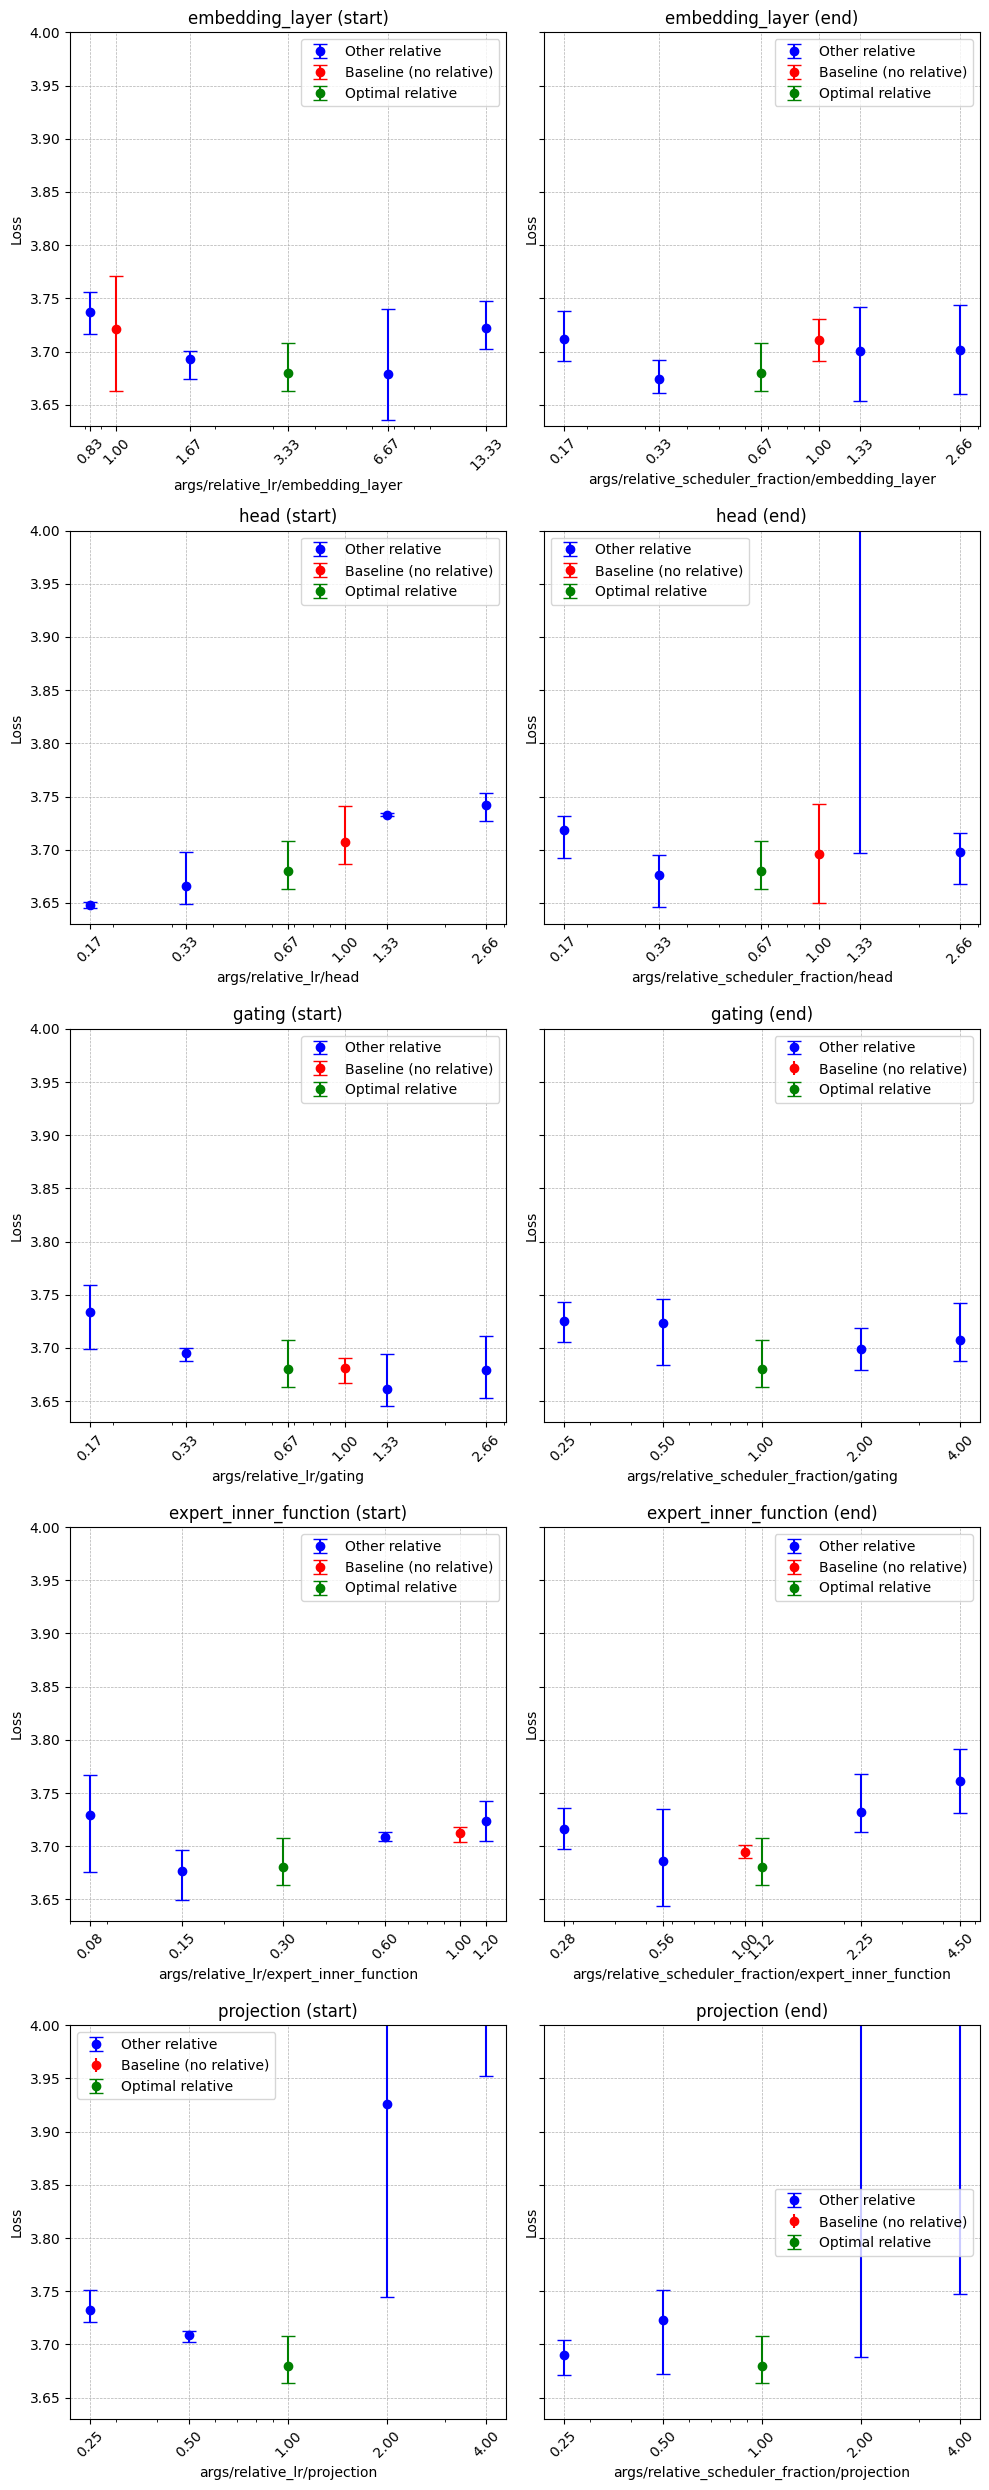

In [18]:
import matplotlib.pyplot as plt
import numpy as np

component_names = ['embedding_layer', 'head', 'gating', 'expert_inner_function', 'projection']
start_ends = ['start', 'end']

# Create subplots with 2 rows and 5 columns
fig, axs = plt.subplots(len(component_names), len(start_ends), sharey=True, figsize=(10, 25))

# Loop through components and start_ends
for i, name in enumerate(component_names):
    for j, start_end in enumerate(start_ends):
        ax = axs[i, j]
        plot_std_component(table=std_medium_df, component_name=name, start_end=start_end, ax=ax)
        ax.set_title(f'{name} ({start_end})')
        for label in ax.get_xticklabels():
            label.set_rotation(45)

for ax in axs.flat:
    ax.set_ylim(3.63, 4)

# Adjust layout to make room for labels
plt.tight_layout()
plt.savefig('U-plots-std.png')
plt.show()

component_name: embedding_layer, start_end: start
x_values: [ 0.83  1.67  6.67 13.33  1.    3.33]


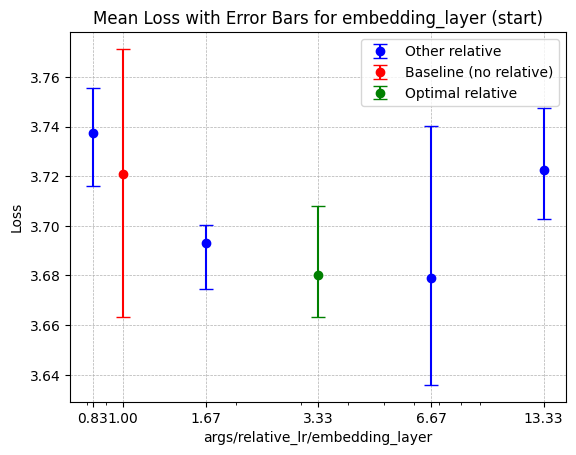

In [19]:
plot_std_component(table=std_medium_df, component_name="embedding_layer", start_end="start")


# Component ablations

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 368)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 368)
run ID: LLMRANDOM-13826
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13826
run ID: LLMRANDOM-13825
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13825
run ID: LLMRANDOM-13824
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13824
run ID: LLMRANDOM-13677
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13677
run ID: LLMRANDOM-13674
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13674
run ID: LLMRANDOM-13563
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13563
gain: 12.730000000000004
ablation loss: 3.712037760416667
baseline loss: 3.36802734375


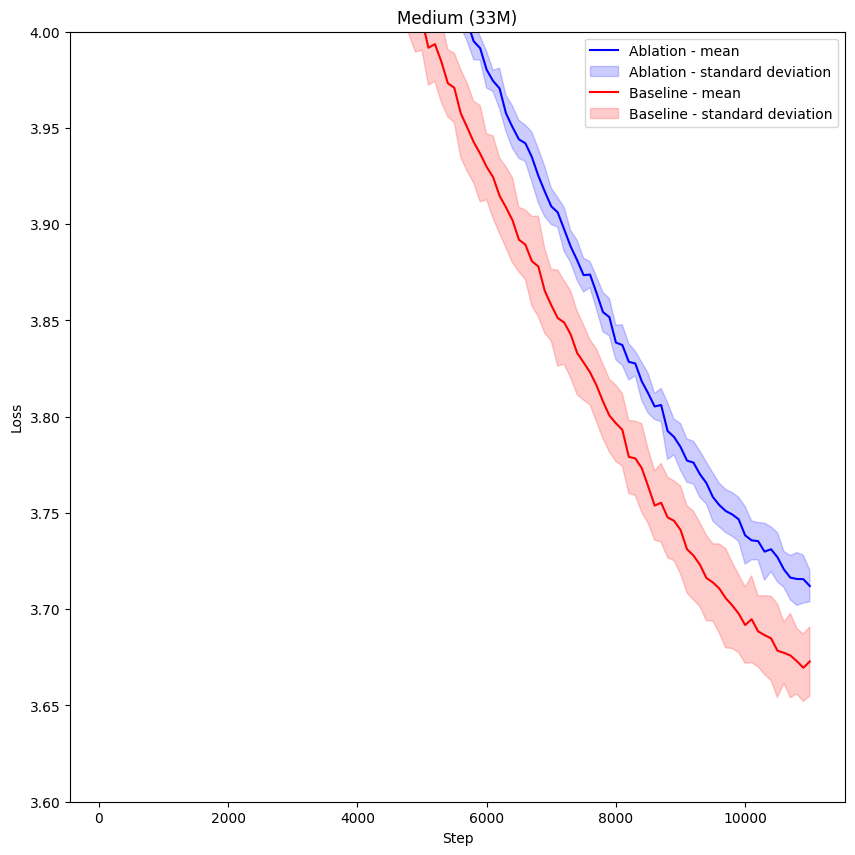

In [20]:
# component_name = 'expert_inner_function'
# component_name = 'gating'
component_name = 'head'
# component_name = 'embedding_layer'

comp_abl = ['relative_lr', 'medium', 'component_ablations', component_name]
comp_abl_baseline = ['relative_lr', 'medium', 'component_ablations', 'relative']

(all_steps, ablation_loss, _), (relative_steps, relative_loss, _), gain = plot_std(
    runs_spec_type='tags',
    runs_1=comp_abl,
    runs_2=comp_abl_baseline,
    title='Medium (33M)',
    name_1='Ablation',
    name_2='Baseline',
    show_plot=False,
    # save_to=f'component_ablations_{component_name}.png',
    ylim=(3.6, 4)
)
print(f'gain: {100 - gain}')
print(f'ablation loss: {ablation_loss}')
print(f'baseline loss: {baseline_loss}')

In [21]:
print(f'gain: {100 - gain}')
tokens_per_step = 128 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000, 0)}M, relative tokens: {round(relative_steps * tokens_per_step / 1000000, 0)}M')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 12.730000000000004
total tokens: 721.0M, relative tokens: 629.0M
std baseline: 0.002189126999109278, std relative: 0.008938206974454375


# BIG models

### MoE

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (1, 640)
run ID: LLMRANDOM-12833
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-12833
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (1, 837)
run ID: LLMRANDOM-12972
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-12972


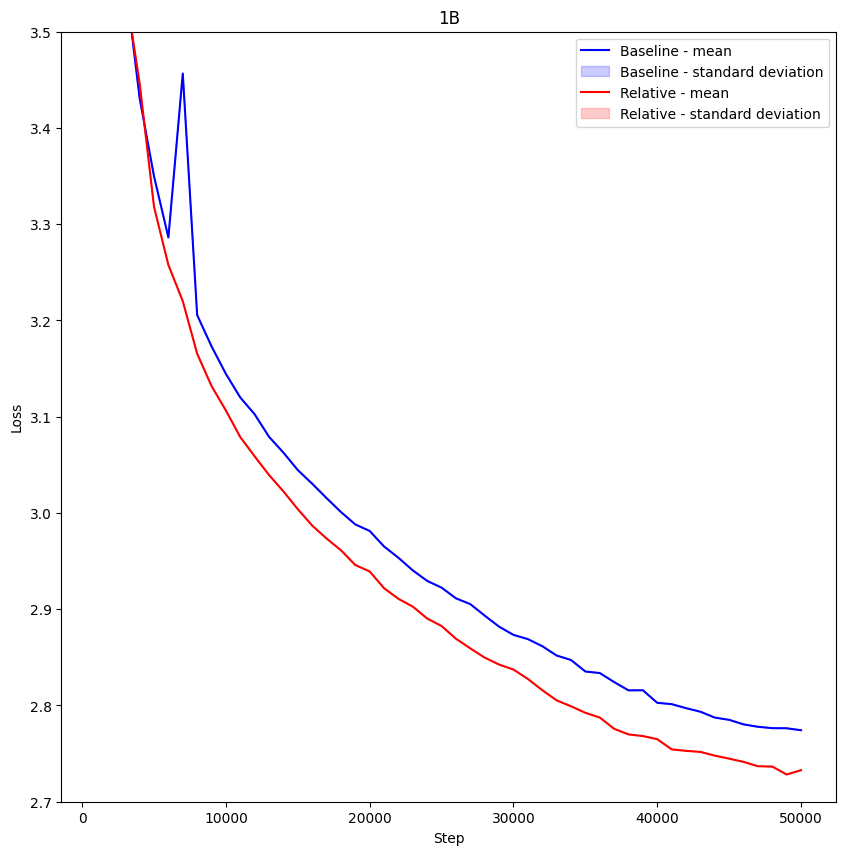

In [93]:
b_v_r_tags_baseline = ['large_extrapolation', 'seq_len_1024', 'sota', 'baseline']
b_v_r_tags_relative = ['large_extrapolation', 'seq_len_1024', 'sota', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    runs_spec_type='tags',
    tags_1=b_v_r_tags_baseline,
    tags_2=b_v_r_tags_relative,
    title='1B',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='1Brelative_vs_baseline.png',
    ylim=(2.7, 3.5),
    # x_start=3000,
    loss_per=1000,
)

In [94]:
print(f'gain: {100 - gain}')
tokens_per_step = 384 * 1024
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000000, 2)}B, relative tokens: {round(relative_steps * tokens_per_step / 1000000000, 2)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 24.0
total tokens: 19.66B, relative tokens: 14.94B
std baseline: 0.0, std relative: 0.0


### Dense

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (1, 476)
run ID: LLMRANDOM-13393
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13393
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (1, 492)
run ID: LLMRANDOM-13404
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13404


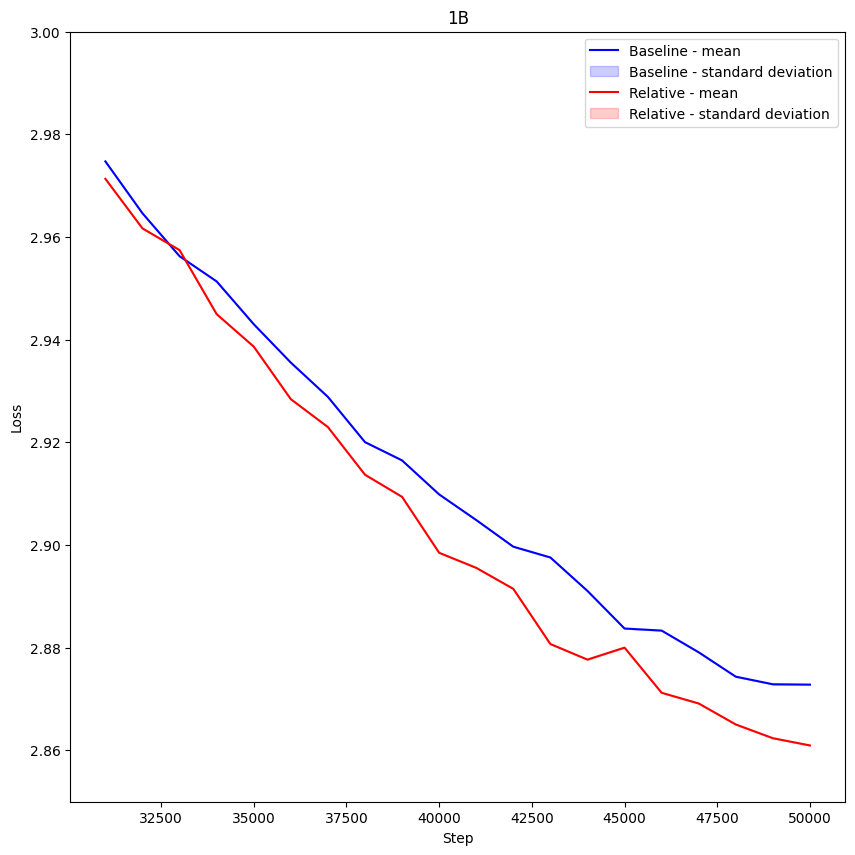

In [101]:
b_v_r_tags_baseline = ['large_extrapolation', 'dense', 'sota', 'baseline']
b_v_r_tags_relative = ['large_extrapolation', 'dense', 'sota', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    tags_1=b_v_r_tags_baseline,
    tags_2=b_v_r_tags_relative,
    title='1B',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='1Brelative_vs_baseline.png',
    ylim=(2.85, 3),
    x_start=30000,
    loss_per=1000,
)

In [102]:
print(f'gain: {100 - gain}')
tokens_per_step = 384 * 1024
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000000, 2)}B, relative tokens: {round(relative_steps * tokens_per_step / 1000000000, 2)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 8.0
total tokens: 19.66B, relative tokens: 18.09B
std baseline: 0.0, std relative: 0.0


### Overtrain

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (1, 509)
run ID: LLMRANDOM-13351
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13351
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (1, 519)
run ID: LLMRANDOM-13349
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13349


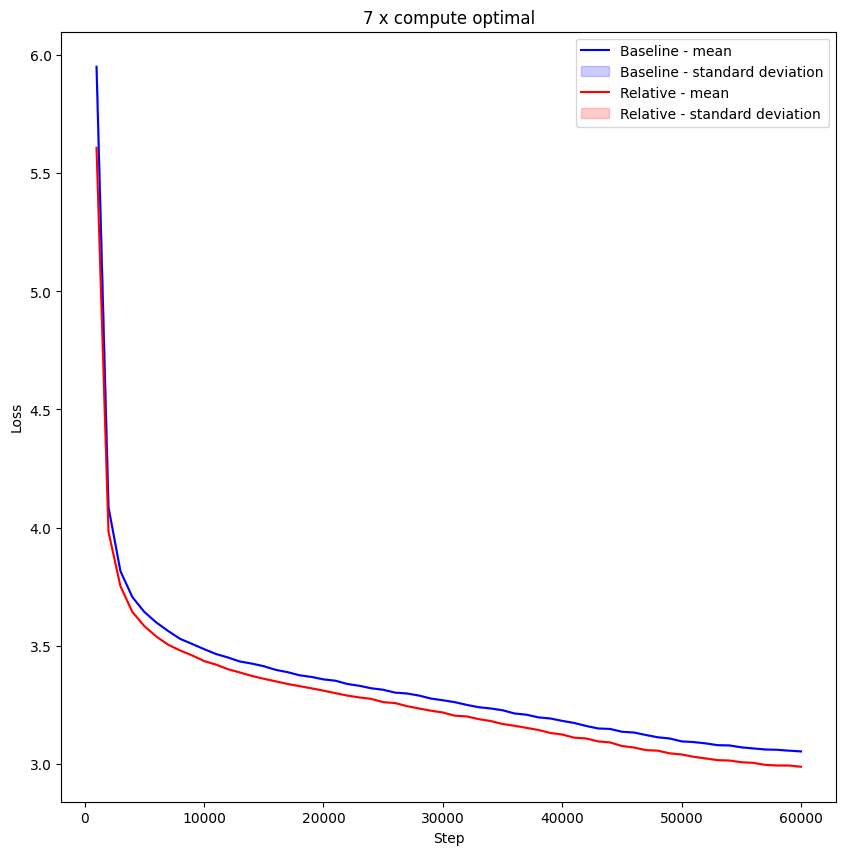

In [106]:
num = 7
b_v_r_tags_baseline = ['base_extrapolation', 'long', 'relative_lr', f'{num}xcmpt_opt', 'baseline']
b_v_r_tags_relative = ['base_extrapolation', 'long', 'relative_lr', f'{num}xcmpt_opt', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    tags_1=b_v_r_tags_baseline,
    tags_2=b_v_r_tags_relative,
    title=f'{num} x compute optimal',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to=f'{num}xcmpt_opt_relative_vs_baseline.png',
    # ylim=(2.85, 3),
    # x_start=30000,
    loss_per=1000,
)

In [107]:
print(f'gain: {100 - gain}')
tokens_per_step = 384 * 1024
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000000, 2)}B, relative tokens: {round(relative_steps * tokens_per_step / 1000000000, 2)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 18.33
total tokens: 23.59B, relative tokens: 19.27B
std baseline: 0.0, std relative: 0.0
